# Synthetic vs Real Data for Autonomous Vehicle Training

In [22]:
# Import all dependencies

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import json
import random
import matplotlib.pyplot as plt 
import torchvision.utils as vutils
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import save_image, make_grid
from ignite.metrics.gan import FID, InceptionScore
import matplotlib.pyplot as plt

# from CGAN.CDCGAN import Generator, Discriminator
from Classifier.ResNet import ResidualNetwork


### Training our Conditional Deep Convolutional Generational Adversarial Network

In [2]:
# Hyperparameters
latent_dim = 512
img_size = 32
channels = 3
embedding_dim = 128
batch_size = 128
n_epochs = 200
sample_interval = 400
lr = 0.0001
b1 = 0.5
b2 = 0.999
resume_epoch = 0


# Load dataset
# Paths
data_root = "Dataset/TrainClean/"

# Dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

print("Total # classes:", n_classes)

# Sample generator output
def sample_image(n_row, batches_done):
    z = torch.randn(n_row ** 2, latent_dim).to(device); 
    labels = torch.tensor([i for i in range(n_row) for _ in range(n_row)], dtype=torch.long).to(device); 
    gen_imgs = generator(z, labels); 
    save_image(gen_imgs.data, f"sample_images/{batches_done}.png", nrow=n_row, normalize=True); 

# Print all hyperparameters
print("Hyperparameters:")
print(f"  latent_dim     = {latent_dim}")
print(f"  img_size       = {img_size}")
print(f"  channels       = {channels}")
print(f"  n_classes      = {n_classes}")
print(f"  embedding_dim  = {embedding_dim}")
print(f"  batch_size     = {batch_size}")
print(f"  n_epochs       = {n_epochs}")
print(f"  sample_interval= {sample_interval}")
print(f"  lr             = {lr}")
print(f"  b1             = {b1}")
print(f"  b2             = {b2}")
print(f"  resume_epocj   = {resume_epoch}")

Class-to-index mapping: {'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14}
Total # classes: 15
Hyperparameters:
  latent_dim     = 512
  img_size       = 32
  channels       = 3
  n_classes      = 15
  embedding_dim  = 128
  batch_size     = 128
  n_epochs       = 200
  sample_interval= 400
  lr             = 0.0001
  b1             = 0.5
  b2             = 0.999
  resume_epocj   = 0


### Generating our Synthetic Training Dataset

In [4]:
# Setup
img_shape = (channels, img_size, img_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fixed_noise = torch.randn(25, latent_dim).to(device)
fixed_labels = torch.randint(0, n_classes, (25,)).to(device)

def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def save_fixed_samples(epoch):
    generator.eval()
    enable_dropout(generator)

    with torch.no_grad():
        fake_imgs = generator(fixed_noise, fixed_labels)
        save_image(fake_imgs, f"checkpoints/fixed_epoch_{epoch}.png", nrow=5, normalize=True)

    generator.train()


In [5]:
# Loss
adversarial_loss = nn.BCELoss()

# Models
from torchvision.utils import save_image 
from torch.nn.utils import spectral_norm 

# Generator
class Generator(nn.Module):
    def __init__(self, n_classes, embedding_dim, latent_dim, img_size, channels):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, embedding_dim)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + embedding_dim, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        out = self.l1(x).view(x.size(0), 128, self.init_size, self.init_size)
        return self.conv_blocks(out)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_size, channels):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, img_size * img_size)
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(channels + 1, 64, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(64, 128, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(128, 256, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            spectral_norm(nn.Conv2d(256, 512, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512 * (img_size // 16) ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(labels.size(0), 1, img.shape[2], img.shape[3])
        d_in = torch.cat((img, label_input), dim=1)
        return self.model(d_in)



# Initialize models
generator = Generator(n_classes, embedding_dim, latent_dim, img_size, channels).to(device)
print("after generator init")
discriminator = Discriminator(n_classes, img_size, channels).to(device)
print("after discriminator init")

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

loss_path = "checkpoints/loss_history.json"

# resume loss recordings
if resume_epoch > 0 and os.path.exists(loss_path):
    with open(loss_path, "r") as f:
        loss_data = json.load(f)
    g_losses = loss_data["g_losses"]
    d_losses = loss_data["d_losses"]
else:
    g_losses = []
    d_losses = []

# resume generator and discriminator
if resume_epoch > 0:
    g_path = f"checkpoints/generator_epoch_{resume_epoch}.pth"
    d_path = f"checkpoints/discriminator_epoch_{resume_epoch}.pth"

    generator.load_state_dict(torch.load(g_path, map_location=device))
    discriminator.load_state_dict(torch.load(d_path, map_location=device))


    if (epoch + 1) % 50 == 0:
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(generator.state_dict(), f"checkpoints/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"checkpoints/discriminator_epoch_{epoch+1}.pth")

        save_fixed_samples(epoch + 1)
        fid, is_mean, is_std = evaluate_metrics(generator, real_dataloader, device)
        print(f"[Epoch {epoch+1}] FID: {fid:.2f}, IS: {is_mean:.2f} ± {is_std:.2f}")
        
        with open("checkpoints/loss_history.json", "w") as f:
            json.dump({"g_losses": g_losses, "d_losses": d_losses}, f)

# Train
for epoch in range(resume_epoch, n_epochs):
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
    for i, (imgs, labels) in enumerate(loop):

        # Move to device
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        real_imgs += 0.05 * torch.randn_like(real_imgs) # add some noise

        # Adversarial ground truths
        valid = torch.full((imgs.size(0), 1), 0.9, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),), device=device)
        gen_imgs = generator(z, gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator 
        optimizer_D.zero_grad()
        real_pred = discriminator(real_imgs, labels)
        real_loss = adversarial_loss(real_pred, valid)
        fake_pred = discriminator(gen_imgs.detach(), gen_labels)
        fake_loss = adversarial_loss(fake_pred, fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Update tqdm bar description
        loop.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())
        
    loop.close()
    print(f"[Epoch {epoch+1}] G_loss: {g_loss.item():.4f}, D_loss: {d_loss.item():.4f}")
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    # Save checkpoints & evaluate
    if (epoch + 1) % 50 == 0:
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(generator.state_dict(), f"checkpoints/generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"checkpoints/discriminator_epoch_{epoch+1}.pth")
    
        save_fixed_samples(epoch + 1)
    
        with open("checkpoints/loss_history.json", "w") as f:
            json.dump({"g_losses": g_losses, "d_losses": d_losses}, f)


after assert
after generator init
after discriminator init


[Epoch 1] G_loss: 0.9715, D_loss: 0.5573


[Epoch 2] G_loss: 0.9002, D_loss: 0.6609


[Epoch 3] G_loss: 0.9125, D_loss: 0.6336


[Epoch 4] G_loss: 0.8825, D_loss: 0.6038


[Epoch 5] G_loss: 0.8065, D_loss: 0.7064


[Epoch 6] G_loss: 0.8626, D_loss: 0.5999


[Epoch 7] G_loss: 0.9337, D_loss: 0.5738


[Epoch 8] G_loss: 1.0219, D_loss: 0.6067


[Epoch 9] G_loss: 1.1288, D_loss: 0.5941


[Epoch 10] G_loss: 1.0271, D_loss: 0.6701


[Epoch 11] G_loss: 1.0999, D_loss: 0.4730


[Epoch 12] G_loss: 0.9198, D_loss: 0.5755


[Epoch 13] G_loss: 1.0859, D_loss: 0.5872


[Epoch 14] G_loss: 1.0070, D_loss: 0.5116


[Epoch 15] G_loss: 1.0631, D_loss: 0.6204


[Epoch 16] G_loss: 1.0930, D_loss: 0.5573


[Epoch 17] G_loss: 1.0001, D_loss: 0.5660


[Epoch 18] G_loss: 1.1138, D_loss: 0.5412


[Epoch 19] G_loss: 0.9668, D_loss: 0.6013


[Epoch 20] G_loss: 0.9735, D_loss: 0.4893


[Epoch 21] G_loss: 1.3746, D_loss: 0.5445


[Epoch 22] G_loss: 1.3154, D_loss: 0.5546


[Epoch 23] G_loss: 1.3392, D_loss: 0.4700


[Epoch 24] G_loss: 1.0581, D_loss: 0.5979


[Epoch 25] G_loss: 1.1039, D_loss: 0.4779


[Epoch 26] G_loss: 1.0942, D_loss: 0.5978


[Epoch 27] G_loss: 1.1486, D_loss: 0.6800


[Epoch 28] G_loss: 0.9769, D_loss: 0.4585


[Epoch 29] G_loss: 0.9352, D_loss: 0.7888


[Epoch 30] G_loss: 1.1341, D_loss: 0.5489


[Epoch 31] G_loss: 0.9688, D_loss: 0.7238


[Epoch 32] G_loss: 1.0098, D_loss: 0.5114


[Epoch 33] G_loss: 1.1309, D_loss: 0.5341


[Epoch 34] G_loss: 1.0634, D_loss: 0.5024


[Epoch 35] G_loss: 0.9047, D_loss: 0.6601


[Epoch 36] G_loss: 0.9193, D_loss: 0.5309


[Epoch 37] G_loss: 1.1843, D_loss: 0.4879


[Epoch 38] G_loss: 1.0277, D_loss: 0.6340


[Epoch 39] G_loss: 1.0886, D_loss: 0.5960


[Epoch 40] G_loss: 1.1413, D_loss: 0.5330


[Epoch 41] G_loss: 1.0354, D_loss: 0.4715


[Epoch 42] G_loss: 1.0114, D_loss: 0.4578


[Epoch 43] G_loss: 1.1084, D_loss: 0.5492


[Epoch 44] G_loss: 0.9833, D_loss: 0.4707


[Epoch 45] G_loss: 1.1799, D_loss: 0.4570


[Epoch 46] G_loss: 1.0470, D_loss: 0.4398


[Epoch 47] G_loss: 1.2155, D_loss: 0.5741


[Epoch 48] G_loss: 1.1984, D_loss: 0.5408


[Epoch 49] G_loss: 1.2399, D_loss: 0.4222


[Epoch 50] G_loss: 0.9285, D_loss: 0.5719


[Epoch 51] G_loss: 1.4381, D_loss: 0.5596


[Epoch 52] G_loss: 1.3538, D_loss: 0.4655


[Epoch 53] G_loss: 1.3846, D_loss: 0.5160


[Epoch 54] G_loss: 1.2280, D_loss: 0.5272


[Epoch 55] G_loss: 1.1911, D_loss: 0.5278


[Epoch 56] G_loss: 1.3503, D_loss: 0.4519


[Epoch 57] G_loss: 1.0671, D_loss: 0.5679


[Epoch 58] G_loss: 1.0276, D_loss: 0.5340


[Epoch 59] G_loss: 1.3540, D_loss: 0.5925


[Epoch 60] G_loss: 1.4174, D_loss: 0.4850


[Epoch 61] G_loss: 0.9901, D_loss: 0.5088


[Epoch 62] G_loss: 1.0739, D_loss: 0.5150


[Epoch 63] G_loss: 1.5394, D_loss: 0.3637


[Epoch 64] G_loss: 1.0334, D_loss: 0.6183


[Epoch 65] G_loss: 1.3384, D_loss: 0.4295


[Epoch 66] G_loss: 1.5471, D_loss: 0.4980


[Epoch 67] G_loss: 1.1245, D_loss: 0.4877


[Epoch 68] G_loss: 1.0661, D_loss: 0.5285


[Epoch 69] G_loss: 1.4832, D_loss: 0.5634


[Epoch 70] G_loss: 1.0449, D_loss: 0.5233


[Epoch 71] G_loss: 1.2936, D_loss: 0.4150


[Epoch 72] G_loss: 1.7283, D_loss: 0.3868


[Epoch 73] G_loss: 1.2690, D_loss: 0.4751


[Epoch 74] G_loss: 1.2563, D_loss: 0.5473


[Epoch 75] G_loss: 1.2712, D_loss: 0.4706


[Epoch 76] G_loss: 1.4671, D_loss: 0.4509


[Epoch 77] G_loss: 1.7252, D_loss: 0.3819


[Epoch 78] G_loss: 1.2644, D_loss: 0.3737


[Epoch 79] G_loss: 1.3853, D_loss: 0.3423


[Epoch 80] G_loss: 1.2402, D_loss: 0.4313


[Epoch 81] G_loss: 1.4363, D_loss: 0.3465


[Epoch 82] G_loss: 1.0962, D_loss: 0.4951


[Epoch 83] G_loss: 1.8409, D_loss: 0.3580


[Epoch 84] G_loss: 1.6296, D_loss: 0.3906


[Epoch 85] G_loss: 1.4422, D_loss: 0.3987


[Epoch 86] G_loss: 1.4203, D_loss: 0.4331


[Epoch 87] G_loss: 1.3655, D_loss: 0.4015


[Epoch 88] G_loss: 1.3878, D_loss: 0.3897


[Epoch 89] G_loss: 1.3339, D_loss: 0.5136


[Epoch 90] G_loss: 1.4573, D_loss: 0.4726


[Epoch 91] G_loss: 1.6519, D_loss: 0.4018


[Epoch 92] G_loss: 1.4743, D_loss: 0.3854


[Epoch 93] G_loss: 1.7338, D_loss: 0.4564


[Epoch 94] G_loss: 1.4781, D_loss: 0.4895


[Epoch 95] G_loss: 1.4707, D_loss: 0.5826


[Epoch 96] G_loss: 1.3452, D_loss: 0.3829


[Epoch 97] G_loss: 1.6330, D_loss: 0.4551


[Epoch 98] G_loss: 1.1762, D_loss: 0.3894


[Epoch 99] G_loss: 1.2991, D_loss: 0.4070


[Epoch 100] G_loss: 1.0086, D_loss: 0.5515


[Epoch 101] G_loss: 1.7046, D_loss: 0.4055


[Epoch 102] G_loss: 1.7769, D_loss: 0.3828


[Epoch 103] G_loss: 1.2986, D_loss: 0.6096


[Epoch 104] G_loss: 1.3934, D_loss: 0.5051


[Epoch 105] G_loss: 1.2035, D_loss: 0.5306


[Epoch 106] G_loss: 1.4316, D_loss: 0.4551


[Epoch 107] G_loss: 1.6490, D_loss: 0.4582


[Epoch 108] G_loss: 1.5105, D_loss: 0.4197


[Epoch 109] G_loss: 1.2711, D_loss: 0.5451


[Epoch 110] G_loss: 1.0718, D_loss: 0.6029


[Epoch 111] G_loss: 1.4692, D_loss: 0.6251


[Epoch 112] G_loss: 1.4667, D_loss: 0.3976


[Epoch 113] G_loss: 1.7960, D_loss: 0.3890


[Epoch 114] G_loss: 1.5758, D_loss: 0.4290


[Epoch 115] G_loss: 1.2093, D_loss: 0.4282


[Epoch 116] G_loss: 1.6232, D_loss: 0.4467


[Epoch 117] G_loss: 1.2594, D_loss: 0.3329


[Epoch 118] G_loss: 1.5605, D_loss: 0.4599


[Epoch 119] G_loss: 1.4325, D_loss: 0.3808


[Epoch 120] G_loss: 1.1066, D_loss: 0.4229


[Epoch 121] G_loss: 1.6167, D_loss: 0.3714


[Epoch 122] G_loss: 1.5480, D_loss: 0.4281


[Epoch 123] G_loss: 1.3078, D_loss: 0.5477


[Epoch 124] G_loss: 1.4770, D_loss: 0.5386


[Epoch 125] G_loss: 1.7146, D_loss: 0.4692


[Epoch 126] G_loss: 1.8361, D_loss: 0.4384


[Epoch 127] G_loss: 1.6966, D_loss: 0.3938


[Epoch 128] G_loss: 1.5969, D_loss: 0.4002


[Epoch 129] G_loss: 1.4582, D_loss: 0.4180


[Epoch 130] G_loss: 1.3086, D_loss: 0.4202


[Epoch 131] G_loss: 1.6076, D_loss: 0.3340


[Epoch 132] G_loss: 1.6834, D_loss: 0.4505


[Epoch 133] G_loss: 1.3903, D_loss: 0.4727


[Epoch 134] G_loss: 1.4735, D_loss: 0.4109


[Epoch 135] G_loss: 1.8870, D_loss: 0.3259


[Epoch 136] G_loss: 1.3778, D_loss: 0.4695


[Epoch 137] G_loss: 1.4662, D_loss: 0.4260


[Epoch 138] G_loss: 1.8344, D_loss: 0.2962


[Epoch 139] G_loss: 1.8062, D_loss: 0.4536


[Epoch 140] G_loss: 1.5465, D_loss: 0.3517


[Epoch 141] G_loss: 1.8045, D_loss: 0.3071


[Epoch 142] G_loss: 1.1340, D_loss: 0.3093


[Epoch 143] G_loss: 1.2896, D_loss: 0.5108


[Epoch 144] G_loss: 1.5050, D_loss: 0.5148


[Epoch 145] G_loss: 1.7630, D_loss: 0.3583


[Epoch 146] G_loss: 1.7614, D_loss: 0.2970


[Epoch 147] G_loss: 1.3071, D_loss: 0.3302


[Epoch 148] G_loss: 1.7951, D_loss: 0.4322


[Epoch 149] G_loss: 1.5942, D_loss: 0.3709


[Epoch 150] G_loss: 1.6649, D_loss: 0.3799


[Epoch 151] G_loss: 1.6212, D_loss: 0.4703


[Epoch 152] G_loss: 1.9168, D_loss: 0.3120


[Epoch 153] G_loss: 1.8659, D_loss: 0.4303


[Epoch 154] G_loss: 1.9713, D_loss: 0.3341


[Epoch 155] G_loss: 1.4403, D_loss: 0.6054


[Epoch 156] G_loss: 1.6236, D_loss: 0.2852


[Epoch 157] G_loss: 1.6658, D_loss: 0.3795


[Epoch 158] G_loss: 2.0056, D_loss: 0.2860


[Epoch 159] G_loss: 1.6047, D_loss: 0.5513


[Epoch 160] G_loss: 1.9956, D_loss: 0.4164


[Epoch 161] G_loss: 1.6765, D_loss: 0.3234


[Epoch 162] G_loss: 1.5238, D_loss: 0.3862


[Epoch 163] G_loss: 1.7473, D_loss: 0.4678


[Epoch 164] G_loss: 1.7443, D_loss: 0.2824


[Epoch 165] G_loss: 1.6574, D_loss: 0.4259


[Epoch 166] G_loss: 1.4927, D_loss: 0.5271


[Epoch 167] G_loss: 1.9375, D_loss: 0.2849


[Epoch 168] G_loss: 1.9763, D_loss: 0.3524


[Epoch 169] G_loss: 1.3918, D_loss: 0.3877


[Epoch 170] G_loss: 1.5055, D_loss: 0.4893


[Epoch 171] G_loss: 1.4817, D_loss: 0.4295


[Epoch 172] G_loss: 1.4528, D_loss: 0.2914


[Epoch 173] G_loss: 1.8906, D_loss: 0.4814


[Epoch 174] G_loss: 2.3504, D_loss: 0.4203


[Epoch 175] G_loss: 1.6207, D_loss: 0.3628


[Epoch 176] G_loss: 1.2673, D_loss: 0.2949


[Epoch 177] G_loss: 1.1863, D_loss: 0.3001


[Epoch 178] G_loss: 1.9536, D_loss: 0.3725


[Epoch 179] G_loss: 1.8424, D_loss: 0.4276


[Epoch 180] G_loss: 1.6753, D_loss: 0.3719


[Epoch 181] G_loss: 1.6450, D_loss: 0.3768


[Epoch 182] G_loss: 1.6112, D_loss: 0.3188


[Epoch 183] G_loss: 1.9273, D_loss: 0.5339


[Epoch 184] G_loss: 1.4522, D_loss: 0.3335


[Epoch 185] G_loss: 1.7302, D_loss: 0.3291


[Epoch 186] G_loss: 1.7444, D_loss: 0.4782


[Epoch 187] G_loss: 1.8024, D_loss: 0.4608


[Epoch 188] G_loss: 2.0287, D_loss: 0.2653


[Epoch 189] G_loss: 1.8599, D_loss: 0.4144


[Epoch 190] G_loss: 2.0787, D_loss: 0.3409


[Epoch 191] G_loss: 1.9560, D_loss: 0.4022


[Epoch 192] G_loss: 2.0342, D_loss: 0.2983


[Epoch 193] G_loss: 1.9015, D_loss: 0.2771


[Epoch 194] G_loss: 1.8172, D_loss: 0.5361


[Epoch 195] G_loss: 2.2096, D_loss: 0.3390


[Epoch 196] G_loss: 1.8377, D_loss: 0.3844


[Epoch 197] G_loss: 1.5956, D_loss: 0.4624


[Epoch 198] G_loss: 1.7077, D_loss: 0.3664


[Epoch 199] G_loss: 1.8975, D_loss: 0.5696


[Epoch 200] G_loss: 1.6295, D_loss: 0.5455


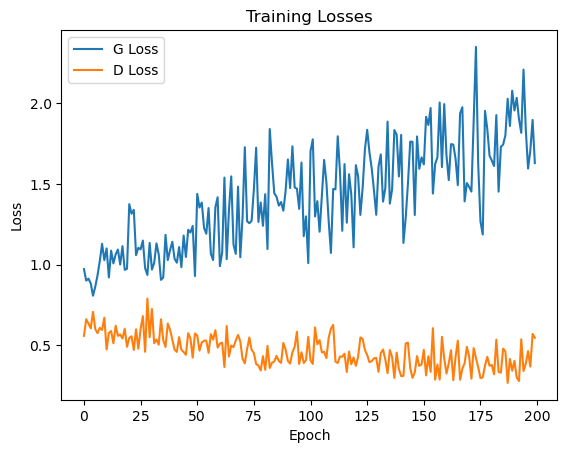

In [6]:
loss_path = "checkpoints/loss_history.json"

if resume_epoch != 0 and os.path.exists(loss_path):
    with open(loss_path, "r") as f:
        data = json.load(f)
    g_loss_data = data["g_losses"]
    d_loss_data = data["d_losses"]
else:
    g_loss_data = g_losses
    d_loss_data = d_losses

plt.plot(g_loss_data, label="G Loss")
plt.plot(d_loss_data, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()
plt.close()


In [7]:
os.makedirs("checkpoints", exist_ok=True)
torch.save(generator.state_dict(), f"checkpoints/generator_epoch_{epoch:03d}.pth")
torch.save(discriminator.state_dict(), f"checkpoints/discriminator_epoch_{epoch:03d}.pth")


In [8]:
def generate_images_per_class(generator, latent_dim, n_classes, total_per_class=300, save_dir="Generated_Dataset/Train"):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)

    total_images = n_classes * total_per_class
    with tqdm(total=total_images, desc="Generating images", leave=True, ncols=100) as pbar:
        with torch.no_grad():
            for class_label in range(n_classes):
                class_dir = os.path.join(save_dir, f"{class_label}")
                os.makedirs(class_dir, exist_ok=True)

                num_generated = 0

                while num_generated < total_per_class:
                    batch_size = min(64, total_per_class - num_generated)
                    z = torch.randn(batch_size, latent_dim).to(device)
                    labels = torch.full((batch_size,), class_label, dtype=torch.long).to(device)

                    gen_imgs = generator(z, labels)

                    for i in range(batch_size):
                        img_tensor = gen_imgs[i].cpu()
                        img_path = os.path.join(class_dir, f"{num_generated + i}.png")
                        vutils.save_image(img_tensor, img_path, normalize=True)

                    num_generated += batch_size
                    pbar.update(batch_size)

generate_images_per_class(
    generator=generator,
    latent_dim=latent_dim,
    n_classes=n_classes,
    total_per_class=300,
    save_dir="Generated_Dataset/Train"
)


Generating images: 100%|███████████████████████████████████████| 4500/4500 [00:09<00:00, 481.40it/s]


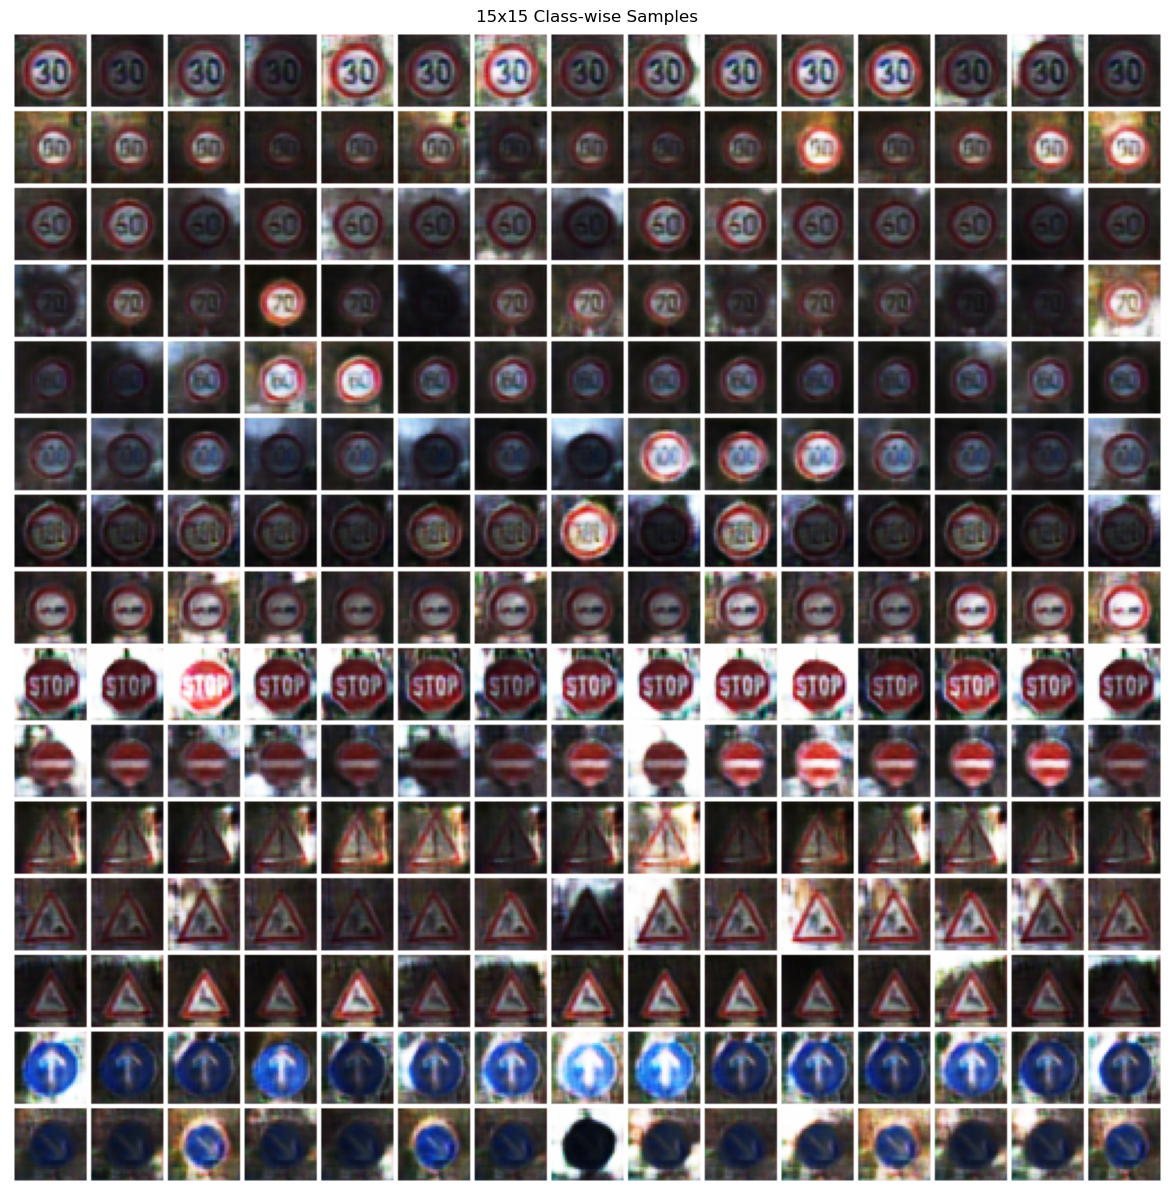

In [24]:
def generate_class_grid(generator, latent_dim, n_classes, grid_size=15, save_path="grid.png"):
    generator.eval()
    assert n_classes <= grid_size, "Grid rows = classes, so grid_size must be ≥ n_classes"

    with torch.no_grad():
        all_imgs = []

        for class_label in range(n_classes):
            z = torch.randn(grid_size, latent_dim).to(device)
            labels = torch.full((grid_size,), class_label, dtype=torch.long).to(device)

            gen_imgs = generator(z, labels)  # (B, C, H, W)
            all_imgs.append(gen_imgs.cpu())

        # Stack rows (n_classes * grid_size, C, H, W)
        grid_imgs = torch.cat(all_imgs, dim=0)
        img_grid = vutils.make_grid(grid_imgs, nrow=grid_size, normalize=True, pad_value=1.0)

        # Save with matplotlib
        plt.figure(figsize=(grid_size, n_classes))
        plt.axis("off")
        plt.title("15x15 Class-wise Samples")
        plt.imshow(img_grid.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
        plt.savefig(save_path, bbox_inches="tight")
        plt.show()

# Usage
generate_class_grid(generator, latent_dim, n_classes=15, grid_size=15, save_path="generated_grid.png")


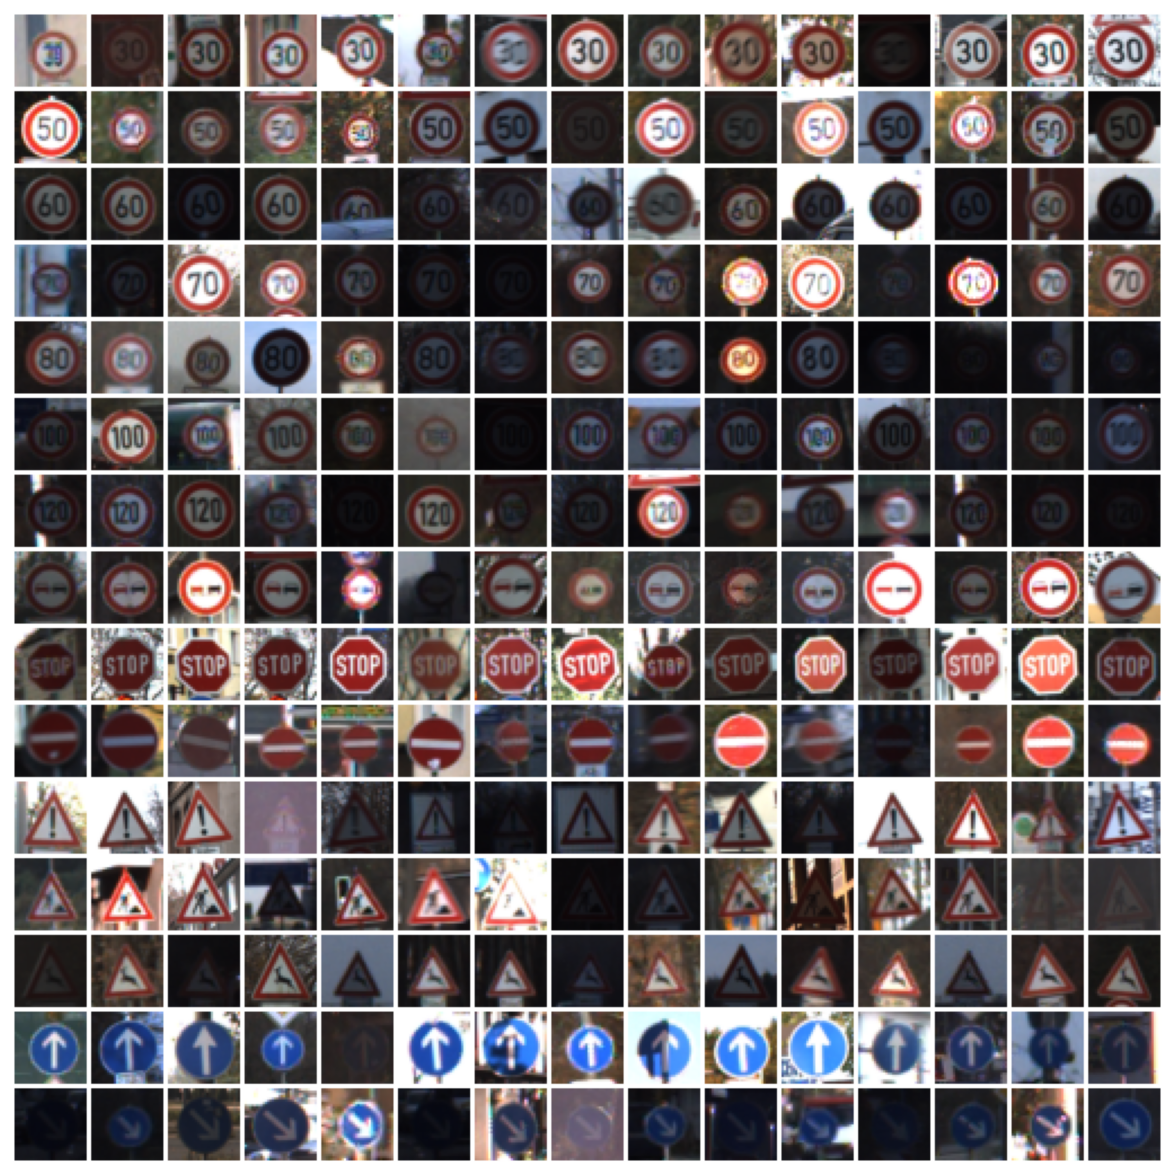

In [25]:
def generate_real_class_grid(dataset, n_classes=15, samples_per_class=15, save_path="real_grid.png", seed=42):
    random.seed(seed)
    class_to_indices = {i: [] for i in range(n_classes)}

    # Index images per class
    for idx, (_, label) in enumerate(dataset.samples):
        if label in class_to_indices:
            class_to_indices[label].append(idx)

    # Randomly sample from each class
    all_imgs = []
    for class_id in range(n_classes):
        indices = class_to_indices[class_id]
        sampled_indices = random.sample(indices, min(samples_per_class, len(indices)))
        for idx in sampled_indices:
            img, _ = dataset[idx]
            all_imgs.append(img)

    img_tensor = torch.stack(all_imgs)

    grid = make_grid(img_tensor, nrow=samples_per_class, normalize=True, pad_value=1)

    # Save and show
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    plt.close()

dataset = datasets.ImageFolder(root="Dataset/Train", transform=transform)

generate_real_class_grid(dataset=dataset, n_classes=15, samples_per_class=15, save_path="real_grid.png")


### Training our Residual Network on Fake Data

/home/dychen/ECE285_VL_DCGAN_SyntheticRealData/Classifier/ResNet.py:48: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(self.conv_1.weight);
/home/dychen/ECE285_VL_DCGAN_SyntheticRealData/Classifier/ResNet.py:16: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(self.conv_1.weight);
/home/dychen/ECE285_VL_DCGAN_SyntheticRealData/Classifier/ResNet.py:18: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(self.conv_2.weight);
Epoch 1/10: 100%|██████████| 36/36 [00:07<00:00,  4.94it/s]


Epoch 1 Loss: 1.2236, Accuracy: 0.7532


Epoch 2/10: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s]


Epoch 2 Loss: 0.1539, Accuracy: 0.9880


Epoch 3/10: 100%|██████████| 36/36 [00:06<00:00,  5.44it/s]


Epoch 3 Loss: 0.0446, Accuracy: 0.9969


Epoch 4/10: 100%|██████████| 36/36 [00:06<00:00,  5.61it/s]


Epoch 4 Loss: 0.0265, Accuracy: 0.9976


Epoch 5/10: 100%|██████████| 36/36 [00:06<00:00,  5.29it/s]


Epoch 5 Loss: 0.0144, Accuracy: 0.9998


Epoch 6/10: 100%|██████████| 36/36 [00:07<00:00,  4.95it/s]


Epoch 6 Loss: 0.0184, Accuracy: 0.9971


Epoch 7/10: 100%|██████████| 36/36 [00:07<00:00,  4.99it/s]


Epoch 7 Loss: 0.0088, Accuracy: 0.9993


Epoch 8/10: 100%|██████████| 36/36 [00:06<00:00,  5.16it/s]


Epoch 8 Loss: 0.0064, Accuracy: 0.9998


Epoch 9/10: 100%|██████████| 36/36 [00:06<00:00,  5.41it/s]


Epoch 9 Loss: 0.0059, Accuracy: 0.9996


Epoch 10/10: 100%|██████████| 36/36 [00:07<00:00,  4.90it/s]


Epoch 10 Loss: 0.0037, Accuracy: 1.0000


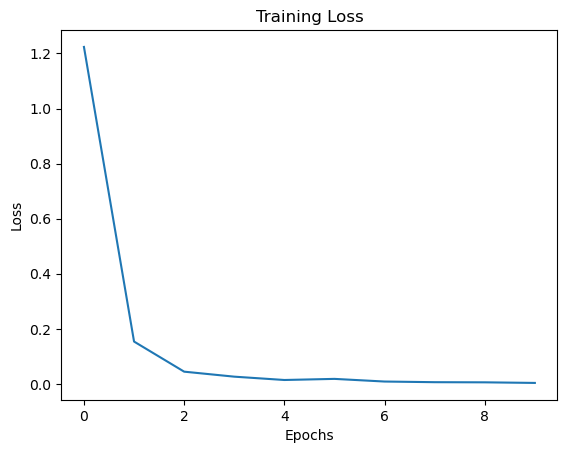

In [10]:
# Training Loop with Fake Dataset

# Dataset path
data_dir = "Generated_Dataset/Train"; 

# Transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Load full dataset
dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

# DataLoaders
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
num_classes = len(dataset.classes); 
resnet_fake = ResidualNetwork(
    in_channel=3,
    channel_1=64,
    channel_2=64,
    channel_3=128,
    channel_4=256,
    channel_5=512,
    number_classes=num_classes
).to(device); 

# Loss and optimizer
criterion = nn.CrossEntropyLoss(); 
optimizer = optim.Adam(resnet_fake.parameters(), lr=1e-4); 

# Training loop
epochs = 10; 
training_losses = []; 
for epoch in range(epochs):
    resnet_fake.train();  
    running_loss = 0.0; 
    correct = 0; 
    total = 0; 

    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device); 

        # Forward
        outputs = resnet_fake(inputs); 
        loss = criterion(outputs, labels); 

        # Backward
        optimizer.zero_grad(); 
        loss.backward(); 
        optimizer.step(); 

        # Metrics
        running_loss += loss.item() * inputs.size(0); 
        _, predicted = torch.max(outputs, 1); 
        total += labels.size(0); 
        correct += (predicted == labels).sum().item(); 

    epoch_loss = running_loss / len(dataset); 
    training_losses.append(epoch_loss); 
    epoch_acc = correct / total; 

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"); 


plt.figure(); 
plt.plot(training_losses, linestyle='-'); 
plt.title("Training Loss"); 
plt.xlabel("Epochs"); 
plt.ylabel("Loss"); 
plt.savefig("ResNet_Loss_Real.png"); 
plt.show();
plt.close(); 


### Training our Residual Network on Real Data

Epoch 1/10: 100%|██████████| 29/29 [00:05<00:00,  5.04it/s]


Epoch 1 Loss: 1.1442, Accuracy: 0.7206


Epoch 2/10: 100%|██████████| 29/29 [00:06<00:00,  4.80it/s]


Epoch 2 Loss: 0.2213, Accuracy: 0.9720


Epoch 3/10: 100%|██████████| 29/29 [00:05<00:00,  5.06it/s]


Epoch 3 Loss: 0.0590, Accuracy: 0.9950


Epoch 4/10: 100%|██████████| 29/29 [00:02<00:00, 10.24it/s]


Epoch 4 Loss: 0.0352, Accuracy: 0.9947


Epoch 5/10: 100%|██████████| 29/29 [00:02<00:00, 11.60it/s]


Epoch 5 Loss: 0.0184, Accuracy: 0.9994


Epoch 6/10: 100%|██████████| 29/29 [00:02<00:00, 11.62it/s]


Epoch 6 Loss: 0.0128, Accuracy: 0.9997


Epoch 7/10: 100%|██████████| 29/29 [00:02<00:00, 11.55it/s]


Epoch 7 Loss: 0.0084, Accuracy: 0.9997


Epoch 8/10: 100%|██████████| 29/29 [00:02<00:00, 11.52it/s]


Epoch 8 Loss: 0.0066, Accuracy: 1.0000


Epoch 9/10: 100%|██████████| 29/29 [00:02<00:00, 11.25it/s]


Epoch 9 Loss: 0.0068, Accuracy: 0.9992


Epoch 10/10: 100%|██████████| 29/29 [00:02<00:00, 11.20it/s]


Epoch 10 Loss: 0.0058, Accuracy: 0.9997


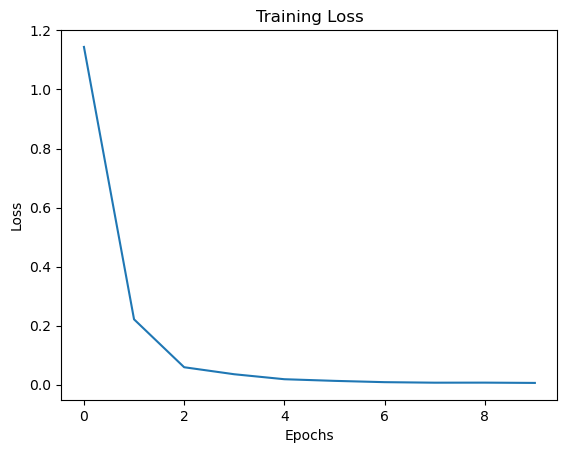

In [11]:
# Training Loop with Real Dataset

# Dataset path
data_dir = "Generated_Dataset/Train"; 

# Transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
]); 

# Load full dataset
dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
); 

# Split into train/test using fixed seed
n_total = len(dataset); 
indices = np.random.RandomState(seed=42).permutation(n_total); 
split = int(n_total * 0.8); 
train_indices = indices[:split]; 
test_indices = indices[split:];  

train_dataset = Subset(dataset, train_indices); 
test_dataset = Subset(dataset, test_indices); 

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True); 
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False); 

# Model
num_classes = len(dataset.classes); 
resnet_real = ResidualNetwork(
    in_channel=3,
    channel_1=64,
    channel_2=64,
    channel_3=128,
    channel_4=256,
    channel_5=512,
    number_classes=num_classes
).to(device); 

# Loss and optimizer
criterion = nn.CrossEntropyLoss(); 
optimizer = optim.Adam(resnet_real.parameters(), lr=1e-4); 

# Training loop
epochs = 10; 
training_losses = []; 
for epoch in range(epochs):
    resnet_real.train();  
    running_loss = 0.0; 
    correct = 0; 
    total = 0; 

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device); 

        # Forward
        outputs = resnet_real(inputs); 
        loss = criterion(outputs, labels); 

        # Backward
        optimizer.zero_grad(); 
        loss.backward(); 
        optimizer.step(); 

        # Metrics
        running_loss += loss.item() * inputs.size(0); 
        _, predicted = torch.max(outputs, 1); 
        total += labels.size(0); 
        correct += (predicted == labels).sum().item(); 

    epoch_loss = running_loss / len(dataset); 
    training_losses.append(epoch_loss); 
    epoch_acc = correct / total; 

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"); 


plt.figure(); 
plt.plot(training_losses, linestyle ='-'); 
plt.title("Training Loss"); 
plt.xlabel("Epochs"); 
plt.ylabel("Loss"); 
plt.savefig("ResNet_Loss_Real.png"); 
plt.show();
plt.close(); 


### Testing our Trained Models

In [12]:
def test_accuracy_per_class(model, dataloader, device, n_classes, model_name="Model"):
    model.eval()
    class_correct = [0] * n_classes
    class_total = [0] * n_classes
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                    total_correct += 1
                class_total[label] += 1
                total_samples += 1

    # Print results
    print(f"\n🔍 Per-Class Accuracy for {model_name}:")
    for i in range(n_classes):
        if class_total[i] > 0:
            acc = 100.0 * class_correct[i] / class_total[i]
            print(f"  Class {i:02d}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")
        else:
            print(f"  Class {i:02d}: No samples")

    overall_acc = total_correct / total_samples if total_samples > 0 else 0
    print(f"\n Overall Accuracy for {model_name}: {overall_acc:.2%} ({total_correct}/{total_samples})")

    return {
        "per_class": {
            i: class_correct[i] / class_total[i] if class_total[i] > 0 else None
            for i in range(n_classes)
        },
        "overall": overall_acc
    }
acc_fake = test_accuracy_per_class(resnet_fake, test_loader, device, n_classes=15, model_name="Fake Trained ResNet")
acc_real = test_accuracy_per_class(resnet_real, test_loader, device, n_classes=15, model_name="Real Trained ResNet")



🔍 Per-Class Accuracy for Fake Trained ResNet:
  Class 00: 100.00% (64/64)
  Class 01: 100.00% (55/55)
  Class 02: 100.00% (72/72)
  Class 03: 100.00% (57/57)
  Class 04: 100.00% (54/54)
  Class 05: 100.00% (53/53)
  Class 06: 100.00% (67/67)
  Class 07: 100.00% (50/50)
  Class 08: 100.00% (47/47)
  Class 09: 100.00% (83/83)
  Class 10: 100.00% (71/71)
  Class 11: 100.00% (63/63)
  Class 12: 100.00% (52/52)
  Class 13: 100.00% (68/68)
  Class 14: 100.00% (45/45)

 Overall Accuracy for Fake Trained ResNet: 100.00% (901/901)

🔍 Per-Class Accuracy for Real Trained ResNet:
  Class 00: 100.00% (64/64)
  Class 01: 100.00% (55/55)
  Class 02: 100.00% (72/72)
  Class 03: 100.00% (57/57)
  Class 04: 100.00% (54/54)
  Class 05: 100.00% (53/53)
  Class 06: 100.00% (67/67)
  Class 07: 100.00% (50/50)
  Class 08: 100.00% (47/47)
  Class 09: 100.00% (83/83)
  Class 10: 100.00% (71/71)
  Class 11: 100.00% (63/63)
  Class 12: 100.00% (52/52)
  Class 13: 100.00% (68/68)
  Class 14: 100.00% (45/45)

 Ov